# One class SVM classification for an imbalanced data set

Date created: Oct 10, 2016   
Last modified: Oct 18, 2016  
Tags: one-class SVM, Random Forest variable importance, imbalanced data set, anomaly detection, feature selection, semiconductor manufacturing data   
About: for an imbalanced semicondutor manufacturing dataset, find explanatory variables with predictive power and build a classifier to detect failures

The [SECOM dataset](http://archive.ics.uci.edu/ml/datasets/SECOM) in the  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml) is semicondutor manufacturing data. There are 1567 records, 590 anonymized features and 104 fails. This makes it an imbalanced with a 14:1 ratio of pass to fails. The process yield has a simple pass/fail response (encoded -1/1).

<h4>Objective</h4>
If the overall objective is to streamline the manufacturing process two things are needed: (i) a good classifier and (ii) feature selection. A streamlined feature set can not only lead to better prediction accuracy and data understanding but also optimize manufacturing resources.  
For this exercise, we will look at: 
- the use of a one-class SVM for an imbalanced data set 
- reducing the number of features to improve classifier performance
 

<h4>Methodology</h4>
The [Variable Importance](http://www.statistik.uni-dortmund.de/useR-2008/slides/Strobl+Zeileis.pdf) is a byproduct of the random forest classifier construction. We will rank the features in order of importance and the first <i>x</i> ranked features will be used for the classifier.
We will then use the one-class SVM (OCSVM) method to classify the data. In the OCSVM, a decision boundary is learned using only the majority class. The minority class data are outliers in this setup. 

<h4>Preprocessing</h4>
The data represents measurements from a large number of processes or sensors; many of the records are missing -- 50-60% of an entire column in 4% of the cases. In addition some measurements are identical/constant and so not useful for prediction. We will remove those columns with high missing count or constant values.<br>
For the random forest classifier, we will impute the remainaing missing values with the median for the column.
For the OCSVM, we will additionally scale the data. We will use the <i>sklearn preprocessing</i> module for both imputing and scaling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split as tts
from sklearn.grid_search import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

from __future__ import division

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_table(url, header=None, delim_whitespace=True)

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

print 'The dataset has {} observations/rows and {} variables/columns.'\
       .format(secom.shape[0], secom.shape[1])
print 'The majority class has {} observations, minority class {}.'\
      .format(y[y == -1].size, y[y == 1].size)
print 'The dataset is imbalanced. \
The ratio of majority class to minority class is {}:1.'\
      .format(int(y[y == -1].size/y[y == 1].size))

The dataset has 1567 observations/rows and 590 variables/columns.
The majority class has 1463 observations, minority class 104.
The dataset is imbalanced. The ratio of majority class to minority class is 14:1.


<h3> Preprocessing </h3>

We will process the missing values first, dropping columns which have a large number of missing values and imputing values for those that have only a few missing values. We will use <i>pandas</i> for this.

In [3]:
# what if all the columns/rows with missing values were removed
nmv = secom.dropna(axis=1)
print 'No. of columns after removing columns with missing data: {}'\
.format(nmv.shape[1])

nmv = secom.dropna(axis=0)
print 'No. of rows after removing rows with missing data: {}'\
.format(nmv.shape[0])

No. of columns after removing columns with missing data: 52
No. of rows after removing rows with missing data: 0


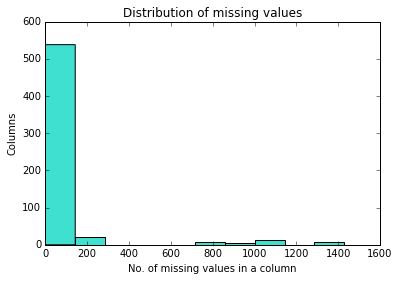

In [4]:
# num of missing entries per column

m = map(lambda x: sum(secom[x].isnull()), xrange(secom.shape[1]))

# distribution of columns with missing entries
plt.hist(m, color='turquoise')
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns")
plt.show()

In [5]:
m_700thresh = filter(lambda i: (m[i] > 700), xrange(secom.shape[1]))
print 'The number of columns with more than 700 missing values: {}'\
.format(len(m_700thresh))
m_200thresh = filter(lambda i: (m[i] > 200), xrange(secom.shape[1]))
print 'The number of columns with more than 200 missing values: {}'\
.format(len(m_200thresh))

The number of columns with more than 700 missing values: 32
The number of columns with more than 200 missing values: 52


In [6]:
# remove columns with more than 200 missing entries

secom_drop_200thresh = secom.dropna(subset=[m_200thresh], axis=1)
print 'No. of columns after dropping columns with more than 200 missing entries: {}'\
.format(secom_drop_200thresh.shape[1])

No. of columns after dropping columns with more than 200 missing entries: 520


In [7]:
# remove columns where every entry is identical (the std. dev = 0)

dropthese = [x for x in secom_drop_200thresh.columns.values \
             if secom_drop_200thresh[x].std() == 0]

print 'There are {} columns which have identical values recorded. \
We will drop these.' .format(len(dropthese))

secom_drop_200thresh.drop(dropthese, axis=1, inplace=True)
print 'The data set now has {} columns.'\
.format(secom_drop_200thresh.shape[1])

There are 111 columns which have identical values recorded. We will drop these.
The data set now has 409 columns.


In [8]:
# checking whether there is a mix of categorical variables

print 'The number of categorical variables is: {}'\
.format(sum((secom_drop_200thresh.dtypes == 'categorical')*1))
secom_drop_200thresh.head(2)

The number of categorical variables is: 0


,0,1,2,3,4,6,8,9,10,11,...,576,577,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,1.5005,0.0162,-0.0034,0.9455,...,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,1.4966,-0.0005,-0.0148,0.9627,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.006,208.2045


In [9]:
# imputing missing values for the random forest

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
secom_imp = pd.DataFrame(imp.fit_transform(secom_drop_200thresh))

<h3> Random Forest Variable Importance</h3>

In addition to prediction the Random Forest can also be used to assess variable importance. In the <i>sklearn</i> [RandomForestClassifier](http://scikit-learn.org/stable/modules/ensemble.html#forest) package this is computed from the total decrease in node impurity when a  predictor is split. There are issues with this computation (there is a bias towards variables with more categories and correlated variables are arbitrarily selected) but we can ignore these since we will be using many variables for the OCSVM classifier. A bigger concern is the imbalance in the data set as this might affect the variable importance ranking.<br>

The SECOM matrix at this point has 409 variables. We will use the Random Forest to rank the variables in terms of their importance.  

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(secom_imp, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [11]:
# displaying features and their rank

importance = rf.feature_importances_
ranked_indices = np.argsort(importance)[::-1]

print "Feature Rank:"
for i in range(15):
    print "{0:3d} column  {1:3d}  {2:6.4f}"\
    .format(i+1, ranked_indices[i], importance[ranked_indices[i]])
print "\n"
for i in xrange(len(importance)-5,len(importance)):
    print "{0:3d} column  {1:3d}  {2:6.4f}"\
    .format(i+1, ranked_indices[i], importance[ranked_indices[i]])

navg = 0
for i in range(len(importance)):    
    if importance[ranked_indices[i]] > np.average(rf.feature_importances_):
        navg = navg+1
print 'The number of features better than average is: {}'.format(navg)        

Feature Rank:
  1 column   55  0.0155
  2 column   50  0.0128
  3 column  311  0.0113
  4 column   56  0.0082
  5 column   34  0.0077
  6 column  351  0.0074
  7 column  131  0.0070
  8 column   21  0.0069
  9 column  219  0.0065
 10 column   85  0.0062
 11 column   65  0.0061
 12 column  230  0.0061
 13 column  232  0.0059
 14 column  310  0.0059
 15 column  382  0.0058


405 column  175  0.0000
406 column  261  0.0000
407 column  264  0.0000
408 column  352  0.0000
409 column   62  0.0000
The number of features better than average is: 148


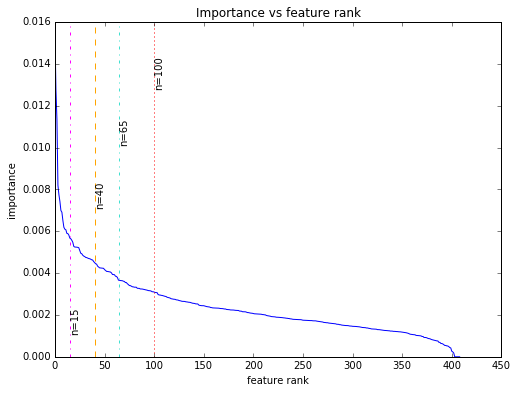

In [12]:
# plot of importance vs the number of features

plt.figure(figsize=(8,6))
plt.plot(range(len(importance)), importance[ranked_indices[:]])
plt.axvline(15, color='magenta', linestyle='dashdot', label='n=15')
plt.axvline(40, color='orange', linestyle='dashed', label='n=40')
plt.axvline(65, color='turquoise', linestyle='dashdot', label='n=65')
plt.axvline(100, color='red', linestyle='dotted', label='n=100')
plt.text(15, 0.002, 'n=15', rotation='vertical')
plt.text(40, 0.008, 'n=40', rotation='vertical')
plt.text(65, 0.011, 'n=65', rotation='vertical')
plt.text(100, 0.014, 'n=100', rotation='vertical')
plt.title('Importance vs feature rank')
plt.xlabel('feature rank')
plt.ylabel('importance')
plt.show()

From this plot, we see points of inflection around the 15, 40, 65 and 100 mark. We will use these to generate 4-5 sets of features to test out on the one-class SVM.  The 50 percentile mark is at 148 so these are reduced feature sets, much smaller than the 409 features we had after cleaning the data. In some of the literature <a href="#ref1">[1]</a> associated with this data set, 40 features were used in the analysis. This was determined by correlation.

<h3> One-class SVM (OCSVM) </h3>

The OCSVM proposed by Schölkopf et al. <a href="#ref2">[2]</a>, <a href="#ref3">[3]</a> can be used to detect negative examples in imbalanced data sets. In the OCSVM, training examples from the majority class are mapped to a feature space circumscribed by a hypersphere; a soft-margin decision boundary is minimized and all points outside are considered outliers. 

<h4>Preprocessing</h4>  

The data is first divided into a majority class train and test set and the minority class test-only set.
The OCSVM is sensitive to feature scale so the first step is to center and normalize the data. The train and test sets are scaled separately using the mean and variance computed from the training data. This is done to estimate the ability of the model to generalize.  

<h4>Parameter Tuning</h4> 

The main parameters are the choice of the <i>kernel</i>, <i>nu</i> and <i>gamma</i>. Some preliminary evaluation showed that the linear and polynomial kernels give poor results. This leaves the <i>rbf</i> kernel for further experimentation.

The hyper-parameters for OCSVM with the <i>rbf</i> kernel are nu ($\nu$) and gamma ($\gamma$).<br>
<ul>
<li> <b>nu:</b> the upper bound for the fraction of margin errors (outliers here) allowed in the data and the lower bound for support vectors relative to the total training examples. It has a range of (0,1). The OCSVM nu can be likened to the SVM parameter <i>C</i> in that both are attached to the penalty term of their respective objective functions.
    <ol>
    <li>Small nu is associated with a smaller margin and higher variance
    <li>Large nu is associated with lower misclassification penalty and low model complexity
    </ol>    
<li> <b>gamma:</b> This is a regularization parameter which for the <i>rbf</i> kernel is equal to $\frac{1}{2\sigma^2}$. It defines the influence of a single training point on points nearby. 
    <ol>
    <li> Low values of gamma (large $\sigma$) imply that training points on or near the decision boundary have high influence. This tends to smoothen the decision boundary (as there are many points exerting an influence) and is related to higher bias. 
    <li> High values of gamma (small $\sigma$) imply that points on the decision boundary exert less influence. This leads to a more flexible curvy decision boundary that is associated with higher variance.
    </ol>    
</ul>


In [28]:
# function for preprocessing, classification, parameter grid search 

def ocsvm_classify(nfeatures, param_grid, printflag=0, printheader=0):
    
    # selecting features and generating a data set
    X_ocsvm   = secom_imp.loc[y == -1,ranked_indices[:nfeatures]]
    X_outlier = secom_imp.loc[y == 1,ranked_indices[:nfeatures]]
    if printflag:
        print "The majority/minority classes have {}/{} observations. \n"\
              .format(X_ocsvm.shape[0], X_outlier.shape[0]) 

    # By convention the majority class has a +1 label
    # and the train and test set belong to the majority class.
    # This is not to be confused with the secom dataset where 
    # the majority class has a -1 label
    y_ocsvm = np.ones(len(X_ocsvm))
    X_train, X_test, y_train, y_test = tts(
    X_ocsvm, y_ocsvm, test_size=0.3, random_state=5)
    
    
    # scaling the split data. The test/outlier data uses scaling parameters 
    # computed from the training data
    standard_scaler = StandardScaler()
    X_train_scaled  = standard_scaler.fit_transform(X_train)
    X_test_scaled   = standard_scaler.transform(X_test)
    X_outlier_scaled  = standard_scaler.transform(X_outlier)
    
    
    # classify for each set of parameters in the grid
    for i in range(len(list(ParameterGrid(param_grid)) )):
        nu = ParameterGrid(param_grid)[i]['nu']
        gamma = ParameterGrid(param_grid)[i]['gamma']
        clf = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=gamma)
        clf.fit(X_train_scaled)
        y_pred_train = clf.predict(X_train_scaled)
        y_pred_test = clf.predict(X_test_scaled)
        y_pred_outlier = clf.predict(X_outlier_scaled)
        
        # calculating error
        n_error_train = y_pred_train[y_pred_train == -1].size
        n_error_test = y_pred_test[y_pred_test == -1].size
        n_error_outlier = y_pred_outlier[y_pred_outlier == 1].size   
    
        # printing results
        if i == 0:
            if printheader:
                print "nfeatures\tnu\tgamma\t train error\t test error\t outlier error"
            print "{0:3d}\t\t{1:3.2f}\t{2:3.2f}\t {3:3d}({4:4.2f}%)\t {5:3d}({6:4.2f}%)\t{7:3d}({8:4.2f}%)"\
            .format(nfeatures, nu, gamma, \
            n_error_train, round(n_error_train/len(y_train) *100, 2),\
            n_error_test, round(n_error_test/len(y_test) *100, 2),\
            n_error_outlier, round(n_error_outlier/len(X_outlier) *100, 2))
        else:
            print "\t\t{0:3.2f}\t{1:3.2f}\t {2:3d}({3:4.2f}%) \t {4:3d}({5:4.2f}%)\t{6:3d}({7:4.2f}%)"\
            .format(nu, gamma, \
            n_error_train, round(n_error_train/len(y_train) *100, 2),\
            n_error_test, round(n_error_test/len(y_test) *100, 2),\
            n_error_outlier, round(n_error_outlier/len(X_outlier) *100, 2))
        

In [29]:
# running a second pass on the tuning matrix (after a coarse first pass)

param_grid = {'nu': [0.03,0.04,0.05], 'gamma': [0.07, 0.08, 0.09, 0.10, 0.15, 0.20]}
ocsvm_classify(40, param_grid, printflag=1, printheader=1)
print "\n"
param_grid = {'nu': [0.1,0.2], 'gamma': [0.04, 0.05, 0.06]}
ocsvm_classify(60, param_grid)  
param_grid = {'nu': [0.1], 'gamma': [0.04, 0.05]}
ocsvm_classify(65, param_grid)
param_grid = {'nu': [0.04,0.05], 'gamma': [0.03, 0.04]}
ocsvm_classify(100, param_grid)
print "\n"
param_grid = {'nu': [0.02,0.03, 0.04], 'gamma': [0.10, 0.15, 0.18, 0.20]}
ocsvm_classify(15, param_grid) 

The majority/minority classes have 1463/104 observations. 

nfeatures	nu	gamma	 train error	 test error	 outlier error
 40		0.03	0.07	 147(14.36%)	 112(25.51%)	 44(42.31%)
		0.04	0.07	 124(12.11%) 	 112(25.51%)	 44(42.31%)
		0.05	0.07	 135(13.18%) 	 112(25.51%)	 44(42.31%)
		0.03	0.08	 157(15.33%) 	 127(28.93%)	 40(38.46%)
		0.04	0.08	 203(19.82%) 	 127(28.93%)	 40(38.46%)
		0.05	0.08	 193(18.85%) 	 127(28.93%)	 40(38.46%)
		0.03	0.09	 169(16.50%) 	 148(33.71%)	 32(30.77%)
		0.04	0.09	 208(20.31%) 	 148(33.71%)	 32(30.77%)
		0.05	0.09	 217(21.19%) 	 148(33.71%)	 32(30.77%)
		0.03	0.10	 203(19.82%) 	 175(39.86%)	 29(27.88%)
		0.04	0.10	 186(18.16%) 	 175(39.86%)	 29(27.88%)
		0.05	0.10	 236(23.05%) 	 175(39.86%)	 29(27.88%)
		0.03	0.15	 374(36.52%) 	 283(64.46%)	 11(10.58%)
		0.04	0.15	 373(36.43%) 	 283(64.46%)	 11(10.58%)
		0.05	0.15	 262(25.59%) 	 283(64.46%)	 11(10.58%)
		0.03	0.20	 396(38.67%) 	 376(85.65%)	  1(0.96%)
		0.04	0.20	 484(47.27%) 	 375(85.42%)	  1(0.96%)
		0.05	0.20	 5

<h3>Observations</h3>

As gamma increases:
*   the outlier classification improves
*   the test error also improves 
*   the train error is not significantly affected

As nu increases:
*   the outlier and test error do not change
*   the training error changes slightly increasing in some cases, decreasing in others

As n, the number of variables, increases:
*   n = 15, train error is much smaller than the outlier error
*   n = 40 - 65: this seems to be the most tunable regime. The best results were obtained when the test error and outlier error were in the low 30% range when n=60 and 65.
*   n = 100: This is also in the tunable range. 

<h3>Discussion</h3>

This parameter grid search was carried out on a single split of the data (rather than cross-validation) but there is an  indication the models have high bias since the train error and test error are both high and also because you can reduce the outlier error by increasing the variance via gamma. 

The best<sup>**</sup> results were obtained when the test error and outlier error were in the low 30% range for n=40 - 65. 

| nfeatures   |      nu      | gamma | train error | test error |outlier error |           
|:----------: |:------------:|:-----:|:----------: |:----------:|:----------:  |        
|40 |0.03  | 0.09  | 169(16.50%)  |	148(33.71%) |  32(30.77%)|
|60 |0.10  | 0.05  | 183(17.87%)  | 133(30.30%) |  34(32.69%)| 
|65 |0.10  | 0.05  |162(15.82%)   |	154(35.08%) | 29(27.88%) |

This however is still too high. The OCSVM on this data set also appears to be difficult to tune so rather than find the optimal hyperparameters through cross-validation we will look at other classification methods. 

<sup>**</sup>Depending on which point in the production flow the data was recorded, one may wish to optimize for False Positives or False Negatives. If you optimize for detecting False Positives early in the production flow, you will  save resources for a device that will be dead in the backend. At the end of the line, detecting false negatives is more important since the chip, which increases in value with each process step, is most valuable at this stage.


<h3> References and Further Reading </h3>

<a name="ref1"></a>[1] [M McCann Y Li L Maguire and A Johnston. "Causality Challenge: Benchmarking relevant signal components for effective monitoring and process control." J. Mach. Learn. Res. Proc. NIPS 2008 workshop on causality](http://www.jmlr.org/proceedings/papers/v6/mccann10a/mccann10a.pdf).

<a name="ref2"></a>[2] [Schölkopf, Bernhard, et al. "Support Vector Method for Novelty Detection." NIPS. Vol. 12. 1999.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.675.575&rep=rep1&type=pdf)

<a name="ref2"></a>[3] [B. Schölkopf, A. Smola, R. Williamson, and P. L. Bartlett. New support vector algorithms. Neural Computation, 12, 2000, 1207-1245.](http://sci2s.ugr.es/keel/pdf/algorithm/articulo/NewSVM.pdf)

[4] [Statnikov, Alexander, et al. "A Gentle Introduction to Support Vector Machines in Biomedicine."](https://www.stat.auckland.ac.nz/~lee/760/SVM%20tutorial.pdf)

[5] [SVM Parameters](http://www.svms.org/parameters/)

<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
email:   meenas.mailbag@gmail.com   <br> 
twitter: @meena_uvaca    <br>
</div>